In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

In [2]:
original_data = False
if original_data:
    input_fn = './non-perturbed_inputs.csv'
    original_fn = './scores_non-perturbed:original_final.csv'
    perturbed_fn = './scores_non-perturbed:perturbed_final.csv'
else:
    input_fn = './perturbed_inputs.csv'
    original_fn = './scores_perturbed:original_final.csv'
    perturbed_fn = './scores_perturbed:perturbed_final.csv'

In [3]:
inputs = pd.read_csv(input_fn)

In [4]:
inputs.head(1)

,example_index,text,sub_index,original,synonym
0,920792,I also tried passing the parameters directly t...,276,nice,good


In [5]:
original = pd.read_csv(original_fn, header=None)
original.columns = ['example_idx', 'w1_prob', 'w2_prob', 'w1_rank', 'w2_rank']
original

,example_idx,w1_prob,w2_prob,w1_rank,w2_rank
0,920792,3.624518e-03,9.212301e-03,42,12
1,930635,2.632344e-02,3.198219e-02,3,2
2,716255,4.664186e-03,1.390163e-02,41,9
3,385756,4.061819e-03,7.141439e-03,27,13
4,976260,2.693949e-03,1.776969e-02,44,3
...,...,...,...,...,...
22495,587478,1.736132e-02,2.311408e-03,3,54
22496,651662,1.382954e-02,1.127626e-03,10,80
22497,720880,1.947260e-02,9.787773e-04,4,133
22498,526108,1.519937e-07,1.678695e-07,12762,11997


In [6]:
perturbed = pd.read_csv(perturbed_fn, header=None)
perturbed.columns = ['example_idx', 'w1_prob', 'w2_prob', 'w1_rank', 'w2_rank']
perturbed

,example_idx,w1_prob,w2_prob,w1_rank,w2_rank
0,920792,2.420170e-03,6.049702e-03,70,23
1,930635,2.659905e-02,4.024825e-02,3,1
2,716255,3.357364e-03,1.155391e-02,49,11
3,385756,3.253927e-03,5.506584e-03,41,13
4,976260,2.535612e-03,1.887857e-02,46,3
...,...,...,...,...,...
22495,587478,1.865367e-02,4.102668e-03,3,22
22496,651662,6.430567e-03,7.944838e-04,16,95
22497,720880,1.971224e-02,7.743267e-04,6,165
22498,526108,1.026309e-07,1.286599e-07,14990,13206


In [11]:
linear_adj = True

In [12]:
propagations = []
for scores in [original, perturbed]:
    df = inputs.join(original)
    
    if linear_adj:
        logistic_models = {}
        for i, g in df.groupby("original"):
            temp_model = LinearRegression().fit(np.log(np.array(g["w1_prob"])).reshape(-1, 1), np.log(g["w2_prob"]))
            logistic_models[i] = temp_model

        def func(row):
            x = np.array(row["w1_prob"]).reshape(1, -1)
            prediction = np.exp(logistic_models[row["original"]].predict(np.log(x))[0])
            return prediction > row["w2_prob"]

        df["prediction"] = df.apply(func, axis=1)
        
    else:
        df['prediction'] = df.w1_prob > df.w2_prob
    df['correctness'] = df['prediction']
    p = df[['synonym', 'correctness']].groupby('synonym').mean()
    propagations.append(p)

<AxesSubplot:xlabel='correctness', ylabel='correctness'>

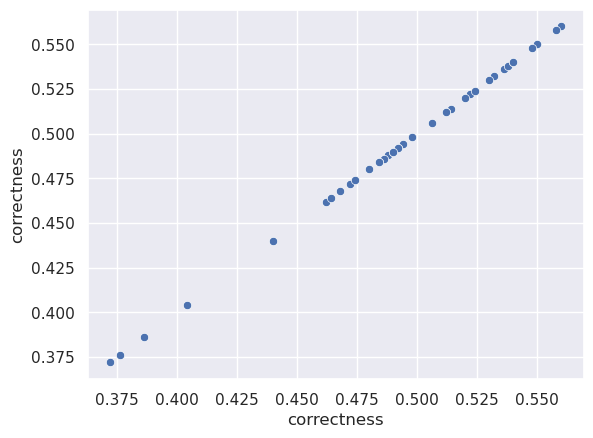

In [13]:
sns.scatterplot(x=propagations[0]['correctness'], y=propagations[1]['correctness'])

In [10]:
propagations[0].sort_values('correctness', ascending=False)

,correctness
synonym,
greater,0.984
assist,0.980
initial,0.978
quite,0.972
proportion,0.954
direction,0.950
evaluation,0.946
exchange,0.946
supply,0.936
